In [55]:
import duckdb
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

path = "/home/etienne/projects/obsq/work/dev/data/data.duckdb"
target = 'expert_match'

pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
scaler = StandardScaler()
from sklearn.feature_selection import mutual_info_regression

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    precision_recall_curve,
    auc,
    f1_score
)
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, precision_recall_curve
from sklearn.preprocessing import StandardScaler

In [58]:
table = 'combined'
schema = 'features'
con = duckdb.connect(path)
df = con.execute(f"""SELECT* FROM {schema}.{table}""" ).df()
#df = df.drop(columns= 'geom')
con.close()

In [59]:
df_pos = df[df['expert_match'] == 1]
df_neg = df[df['expert_match'] == 0]

In [60]:
#Set index from gbifID
df = df.set_index('gbifID')


In [61]:
def plot_mean_response(df, x):
    df.groupby(x)[target].mean().plot(kind="bar")
    plt.ylabel("P(y=1 | x)")
    plt.xlabel("x")
    plt.show()

In [62]:
def plot_3d_df(df):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    # 4. Plot the data using Matplotlib's 3D function
    # You can use a Seaborn color palette here as a colormap for the 'c' argument
    scatter = ax.scatter(df.iloc[:,0], df.iloc[:,1], df.iloc[:,2], 
                        
                        s=50) # 's' controls marker size
    ax.set_xlabel("pca_0")
    ax.set_ylabel("pca_1")
    ax.set_zlabel("pca_2")

In [63]:
def plot_cat_rate(df, cat_col):
    output = "home/etienne/projects/obsq/eda"
    rates = (
        df.groupby(cat_col)[target]
        .mean()
        .sort_values()
    )
    sns.barplot(x=rates.index[:20], y=rates.values[:20])
    plt.xticks(rotation=45, ha='right')   # or rotation=60, ha='right'
    plt.title(f"Observations rates for {cat_col}", fontsize=16)
    plt.savefig(f"{output}/{cat_col}_target_rates.jpg", dpi = 300, bbox_inches="tight")

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36164 entries, 4952691517 to 3759271213
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   expert_match                        36164 non-null  int32  
 1   observer_pca0                       36164 non-null  float64
 2   observer_pca1                       36164 non-null  float64
 3   histo_taxon_ttl_obs_count           36164 non-null  int32  
 4   histo_taxon_obs_month_density       36164 non-null  float32
 5   cmva_id_count                       36164 non-null  int64  
 6   cmva_id_agree_rate                  36163 non-null  float64
 7   cmva_id_time                        36164 non-null  int64  
 8   cmva_expert_id                      36164 non-null  int32  
 9   tempo_day                           36164 non-null  int64  
 10  tempo_month                         36164 non-null  int64  
 11  tempo_year                      

In [65]:
df.describe()

,expert_match,observer_pca0,observer_pca1,histo_taxon_ttl_obs_count,histo_taxon_obs_month_density,cmva_id_count,cmva_id_agree_rate,cmva_id_time,cmva_expert_id,tempo_day,...,pheno_leaves_month_density,pheno_sex_month_density,pheno_repro_month_density,taxo_freq,taxo_confusability_index,gee_pca0,gee_pca1,gee_pca2,gee_pca3,spatial_cluster
count,36164.00000,36164.00000,36164.00000,36164.00000,36164.00000,36164.00000,36163.00000,36164.00000,36164.00000,36164.00000,...,1683.00000,76.00000,2847.00000,36164.00000,36164.00000,36164.00000,36164.00000,36164.00000,36164.00000,36164.00000
mean,0.06675,-54.62962,395.32505,517.32201,0.17508,1.23460,0.99878,22.88240,0.04811,15.89326,...,0.29691,0.50489,0.29900,0.79969,4.05821,0.01769,-0.01239,-0.00984,0.00163,2.63287
std,0.24959,206.98976,614.24264,1306.88818,0.26377,0.52231,0.01756,99.21467,0.21401,9.21334,...,0.20354,0.27158,0.27191,1.60529,7.75600,144.77226,41.37677,16.95808,10.54791,1.70762
min,0.00000,-161.70439,-21.45291,6.00000,0.00000,0.00000,0.66670,0.00000,0.00000,1.00000,...,0.00600,0.02700,0.00000,0.00100,0.00000,-199.00847,-194.28831,-95.87271,-45.65685,0.00000
25%,0.00000,-150.50913,23.76387,6.00000,0.00000,1.00000,1.00000,0.00000,0.00000,7.00000,...,0.14700,0.23600,0.08900,0.04600,0.00000,-139.15238,-9.84309,-11.73240,-5.25413,1.00000
50%,0.00000,-132.88400,129.03148,6.00000,0.00000,1.00000,1.00000,1.00000,0.00000,16.00000,...,0.24300,0.56600,0.19700,0.13500,0.00000,-20.21458,5.97727,5.30538,1.29059,3.00000
75%,0.00000,-58.17582,384.08067,6.00000,0.29861,1.00000,1.00000,3.00000,0.00000,24.00000,...,0.38500,0.60900,0.51700,0.49800,3.00000,95.36073,13.12262,11.84674,8.62983,4.00000
max,1.00000,2791.00880,1933.89562,7839.00000,0.84536,7.00000,1.00000,1618.00000,1.00000,31.00000,...,1.00000,1.00000,1.00000,9.37100,24.00000,860.65115,155.52897,37.35730,29.62334,5.00000


In [70]:

X = df.copy().drop(columns=[target])
y = df[target]
X


,observer_pca0,observer_pca1,histo_taxon_ttl_obs_count,histo_taxon_obs_month_density,cmva_id_count,cmva_id_agree_rate,cmva_id_time,cmva_expert_id,tempo_day,tempo_month,...,pheno_leaves_month_density,pheno_sex_month_density,pheno_repro_month_density,taxo_freq,taxo_confusability_index,gee_pca0,gee_pca1,gee_pca2,gee_pca3,spatial_cluster
gbifID,,,,,,,,,,,,,,,,,,,,,
4952691517,-161.70439,1933.89562,1062,0.09040,1,1.00000,10,0,10,7,...,0.20000,NaN,0.14400,0.05700,0,-5.74652,3.66671,9.38831,10.82902,1
5134071604,-161.70439,1933.89562,6,0.00000,1,1.00000,5,0,12,4,...,0.22900,NaN,0.05500,2.74300,24,-44.84367,10.69111,8.18523,7.58560,1
5292748633,-69.42477,292.10692,6,0.00000,1,1.00000,12,0,1,7,...,0.18900,NaN,0.76700,1.61900,24,-145.79223,3.55552,-16.85087,5.17230,5
5206462574,-120.18900,10.12328,6,0.66667,1,1.00000,2,0,27,5,...,0.05300,NaN,0.12500,0.01000,0,-93.42302,-0.09138,16.17648,12.09848,1
4978265028,-161.70439,1933.89562,6,0.00000,1,1.00000,3,0,9,7,...,0.09100,NaN,0.23800,0.12600,0,67.41128,-8.42319,6.87742,13.50345,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3455825209,-155.87174,101.64567,3744,0.09268,1,1.00000,0,0,3,8,...,NaN,NaN,0.04800,9.37100,24,-154.54382,3.19284,-25.28399,0.16299,5
4936428726,-149.83100,26.98640,6,0.00000,1,1.00000,1,0,25,8,...,0.16400,0.33300,NaN,0.00500,0,370.22071,-77.13658,-28.23889,-16.30112,0
4868108385,-156.84272,719.75525,3744,0.19685,1,1.00000,1,0,15,5,...,0.19300,0.39100,NaN,9.37100,24,-162.14117,9.09773,-18.45419,-1.66272,5


In [76]:
X.fillna(0, inplace=True)

In [77]:
discrete_features = X.dtypes == int
discrete_features

observer_pca0                         False
observer_pca1                         False
histo_taxon_ttl_obs_count             False
histo_taxon_obs_month_density         False
cmva_id_count                          True
cmva_id_agree_rate                    False
cmva_id_time                           True
cmva_expert_id                        False
tempo_day                              True
tempo_month                            True
tempo_year                             True
meta_media_count                      False
meta_coordinateUncertaintyInMeters    False
meta_pheno_repro                      False
meta_pheno_leaves                     False
meta_pheno_sex                        False
meta_occurrenceRemarks                 True
species_encoded                        True
pheno_leaves_month_density            False
pheno_sex_month_density               False
pheno_repro_month_density             False
taxo_freq                             False
taxo_confusability_index        

In [78]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

gee_pca3                             0.05933
gee_pca2                             0.05213
species_encoded                      0.03468
cmva_id_time                         0.00957
meta_coordinateUncertaintyInMeters   0.00805
taxo_freq                            0.00687
meta_pheno_repro                     0.00328
meta_pheno_leaves                    0.00090
meta_pheno_sex                       0.00000
tempo_year                           0.00000
Name: MI Scores, dtype: float64

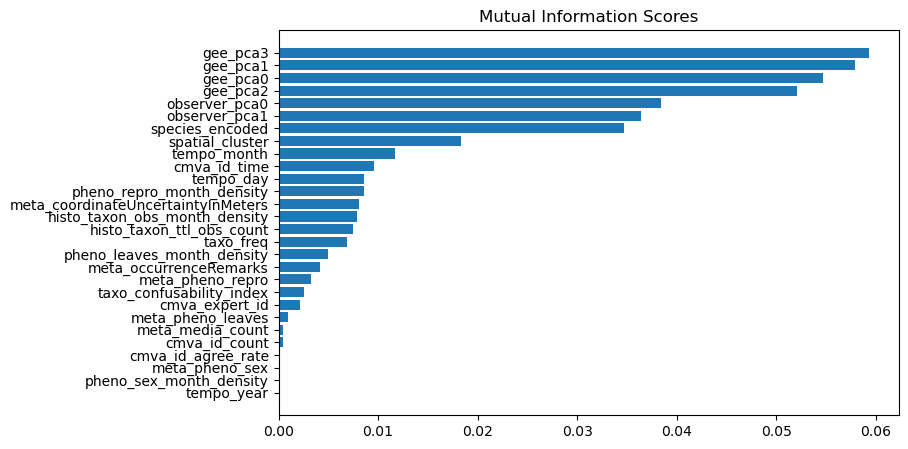

In [79]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

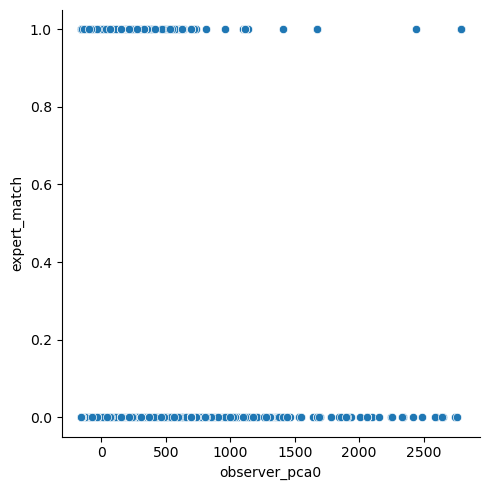

In [93]:
sns.relplot(x="observer_pca0", y=target, data=df)


In [10]:
df.var(numeric_only = True).sort_values(ascending=False)


histo_taxon_ttl_obs_count            1707956.72674
observer_pca1                         377294.01657
meta_coordinateUncertaintyInMeters    117994.80045
species_encoded                        47460.88900
observer_pca0                          42844.76087
gee_pca0                               20959.00591
cmva_id_time                            9843.55050
gee_pca1                                1712.03721
meta_occurrenceRemarks                  1170.80985
gee_pca2                                 287.57664
meta_media_count                         156.83798
gee_pca3                                 111.25846
tempo_day                                 84.88560
taxo_confusability_index                  60.15548
spatial_cluster                            2.91598
taxo_freq                                  2.57694
tempo_year                                 2.03698
tempo_month                                1.57220
cmva_id_count                              0.27281
meta_pheno_repro               

<Axes: >

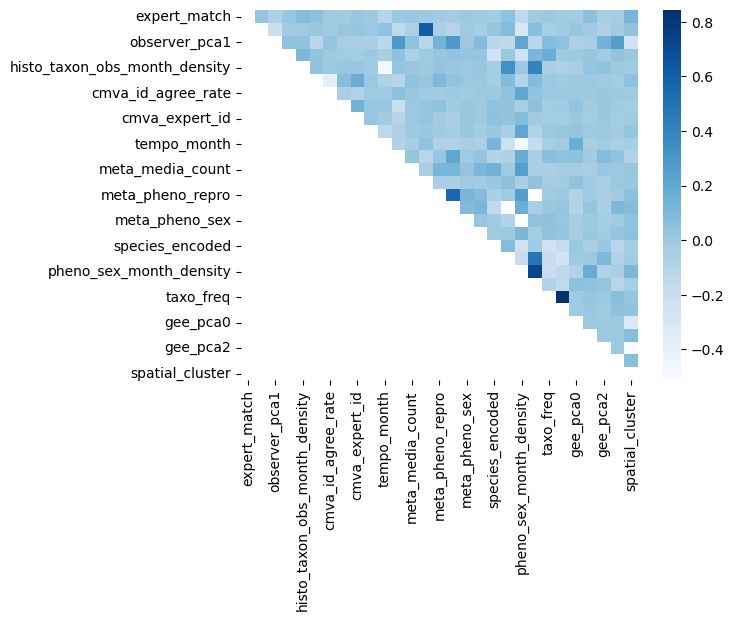

In [11]:
corr = df.corr(numeric_only=True)
upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

sns.heatmap(upper_tri, cmap='Blues',)

In [12]:
highly_correlated_pairs = upper_tri.stack().sort_values(ascending=False)
highly_correlated_pairs

taxo_freq                      taxo_confusability_index              0.84189
pheno_sex_month_density        pheno_repro_month_density             0.72859
observer_pca0                  meta_coordinateUncertaintyInMeters    0.59937
meta_pheno_repro               meta_pheno_leaves                     0.55583
pheno_leaves_month_density     pheno_repro_month_density             0.48751
                                                                      ...   
gee_pca0                       spatial_cluster                      -0.32126
cmva_id_count                  cmva_id_agree_rate                   -0.37848
tempo_month                    pheno_sex_month_density              -0.47677
histo_taxon_obs_month_density  tempo_month                          -0.47798
gee_pca2                       spatial_cluster                      -0.51217
Length: 403, dtype: float64

In [13]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column].abs() > 0.8)]
to_drop

['taxo_confusability_index']

In [87]:
columns = df.select_dtypes(include='number').columns.tolist()
print(len(columns))

strong_sep = []
moderate_sep = []
low_sep = []
skip = ['gbifID', 'expert_match']

for c in columns:
    if c in skip:
        continue 
    pos_mean = df_pos[c].mean()
    neg_mean = df_neg[c].mean()
    pos_std = df_pos[c].std()
    cohens_d = (pos_mean - neg_mean) / pos_std
    #print(f"\n{c}: ", round(abs(cohens_d),3))
    if abs(cohens_d) > 0.5:
        #print("  ✓ Strong separation - likely useful!")
        strong_sep.append(c)
    elif abs(cohens_d) > 0.2:
        #print("  ⚠ Moderate separation - may be useful")
        moderate_sep.append(c)
    else:
        #print("  ✗ Weak separation - may not help")
        low_sep.append(c)

29


In [88]:
strong_sep

['pheno_sex_month_density', 'spatial_cluster']

In [16]:
moderate_sep

['observer_pca1', 'histo_taxon_obs_month_density', 'tempo_month', 'gee_pca1']

In [17]:
low_sep

['observer_pca0',
 'histo_taxon_ttl_obs_count',
 'cmva_id_count',
 'cmva_id_agree_rate',
 'cmva_id_time',
 'cmva_expert_id',
 'tempo_day',
 'tempo_year',
 'meta_media_count',
 'meta_coordinateUncertaintyInMeters',
 'meta_pheno_repro',
 'meta_pheno_leaves',
 'meta_pheno_sex',
 'meta_occurrenceRemarks',
 'species_encoded',
 'pheno_leaves_month_density',
 'pheno_repro_month_density',
 'taxo_freq',
 'taxo_confusability_index',
 'gee_pca0',
 'gee_pca2',
 'gee_pca3']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
n_samples = len(y_train)
n_pos = y_train.sum()
n_neg = n_samples - n_pos
scale_pos_weight = n_neg / n_pos

In [38]:
model = LogisticRegression(solver='liblinear', class_weight='balanced',max_iter=1000, random_state=0) # 'lbfgs' is default in newer versions

In [45]:
model = RandomForestClassifier(
                n_estimators=500,
                class_weight='balanced',
                max_depth=10,
                random_state=42,
                n_jobs=-1
            )

In [46]:
model = XGBClassifier(
                n_estimators=500,
                max_depth=7,
                scale_pos_weight=scale_pos_weight,
                learning_rate=0.1,
                random_state=42,
                eval_metric='logloss')


In [47]:
model.fit(X_train_scaled, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [48]:
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model (e.g., accuracy, confusion matrix, classification report)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred))
print("Classification Report:\n", metrics.classification_report(y_test, y_pred))

Accuracy: 0.9423736312354828
Confusion Matrix:
 [[8171  266]
 [ 255  349]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      8437
           1       0.57      0.58      0.57       604

    accuracy                           0.94      9041
   macro avg       0.77      0.77      0.77      9041
weighted avg       0.94      0.94      0.94      9041



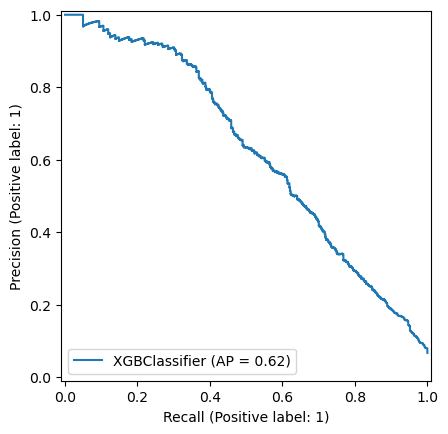

In [53]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
PrecisionRecallDisplay.from_estimator(
   model, X_test_scaled, y_test)

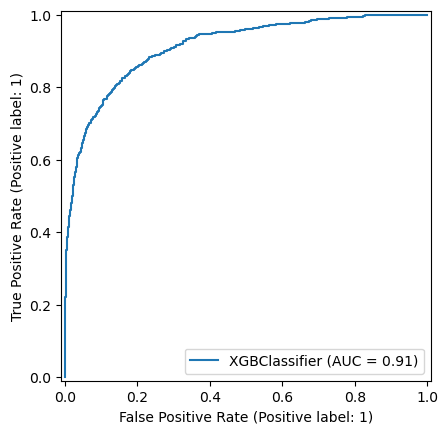

In [54]:
RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)

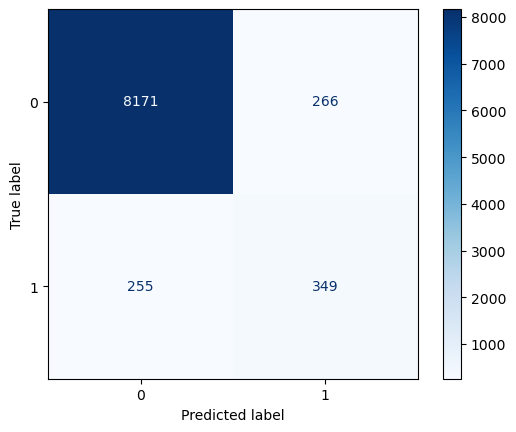

In [52]:
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')